In [1]:
import numpy as np
import pandas as pd
import config
import time
import matplotlib.pyplot as plt
plt.style.use("ggplot")
#from numba import jit
import sys
from ast import literal_eval
from scipy.stats import beta
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from scipy.sparse import csgraph
from scipy.linalg import eigvals
from sklearn.cluster import SpectralClustering

In [2]:
def get_samples(species):
    data_dir = config.data_directory
    snps_dir = f"{data_dir}snps/{species}"

    hosts = ["am","ae","ao","an"]
    tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")
    samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))

    samples_between = {}

    for host in hosts: 
        samples_host = config.Poyet_samples[host]
        samples_host = tp_matched[samples_host].sort_values().index
        samples_host = [sample for sample in samples_host if sample in samples_all]    
        L = len(samples_host)
        #if L > 4:
        #    samples_between[host] = [samples_host[0],samples_host[int(L/4)],samples_host[int(L/2)],samples_host[int(3*L/4)], samples_host[-1]]
        samples_between[host] = samples_host
    return samples_between

In [115]:
data_dir = config.data_directory
species = "Faecalibacterium_prausnitzii_61481"
#species = "Bacteroides_fragilis_54507"
hosts = ["am","ae","ao","an"]
host = "ao"
snps_dir = f"{data_dir}snps/{species}"
species_dir = f"{data_dir}species/"
rel_ab = pd.read_csv(f"{species_dir}/relative_abundance.txt.bz2",sep="\t",index_col=0)
rel_ab = rel_ab.loc[species]
tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")
samples_host = config.Poyet_samples[host]
samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))
samples_host = [sample for sample in samples_host if sample in samples_all]

In [116]:
info = pd.read_csv(f"{snps_dir}/snps_info.txt.bz2",index_col=0,sep="\t")

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [206]:
tp_ordered = tp_matched.loc[samples_host].sort_values().index

In [207]:
rel_ab.loc[tp_ordered].shape

(88,)

[]

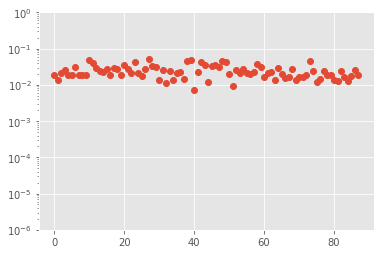

In [208]:
plt.plot(list(rel_ab.loc[tp_ordered]),'o')
plt.ylim([1e-6,1])
plt.semilogy()

In [169]:
out_path = f"{config.analysis_directory}pi/{species}"

pi_df = pd.read_csv(f"{out_path}/{species}_pi.txt",index_col=0)
fst_df= pd.read_csv(f"{out_path}/{species}_fst.txt",index_col=0)

In [170]:
samps = get_samples(species)

In [171]:
species

'Faecalibacterium_prausnitzii_61481'

In [172]:
host = ["am","ao"]
fst_df.loc[samps[host],samps[host]]

TypeError: unhashable type: 'list'

In [ ]:
data_dir = config.data_directory
snps_dir = f"{data_dir}snps/{species}"

hosts = ["am","ae","ao","an"]
tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")
samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))

samples_between = {}

for host in hosts: 
    samples_host = config.Poyet_samples[host]
    samples_host = tp_matched[samples_host].sort_values().index
    samples_host = [sample for sample in samples_host if sample in samples_all]    
    L = len(samples_host)
    if L > 0:
        #samples_between[host] = [samples_host[0],samples_host[int(L/4)],samples_host[int(L/2)],samples_host[int(3*L/4)], samples_host[-1]]
        samples_between[host] = samples_host

In [117]:
## implement pi within estimate from Schloissnig (2013)
chunk_size = 40000
#host = "am"
#samples= list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))
#species = "Bacteroides_vulgatus_57955"
snps_dir = f"{data_dir}snps/{species}"

#host = "am"
samples_between = get_samples(species)
samples_host = np.array(samples_between[host])
samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))
samples_host = [sample for sample in samples_host if sample in samples_all]
#samples_host = samples_host[[0,-1]]
#samples_host = ['SRR9224122', 'SRR9224355', 'SRR9224054', 'SRR9224497', 'SRR9224100']
pi_vals = pd.DataFrame(0,index=samples_host,columns=samples_host)
df_depth_reader = pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0,iterator=True,low_memory=False)
df_refreq_reader = pd.read_csv(f"{snps_dir}/snps_ref_freq.txt.bz2",sep="\t",index_col=0, iterator=True,low_memory=False)

df_depth = df_depth_reader.get_chunk(1)
df_refreq = df_refreq_reader.get_chunk(1)

tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")

t1 = time.time()
reader=True
i=0
S=0
G = 0 
#G=pd.DataFrame(0,index=samples_host,columns=samples_host)

min_depth = 5

#samples_host = config.Poyet_samples[host]
#samples_all = list(pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0, nrows=0))
#samples_host = [sample for sample in samples_host if sample in samples_all]
L = len(samples_host)
var_sites_df = pd.DataFrame(columns=samples_host)
var_sites_depth_df = pd.DataFrame(columns=samples_host)

while reader:
    
    df_depth = df_depth_reader.get_chunk(chunk_size)
    df_refreq = df_refreq_reader.get_chunk(chunk_size)
    
    df_depth = df_depth[samples_host]
    df_refreq = df_refreq[samples_host]
    
    if df_depth.shape[0] < chunk_size:
        reader=False
        print("Complete")
        
    #medians = df_depth.T.median()
    #good_inds = medians[medians >= 5].index
    #good_inds = df_depth[(df_depth > 5).all(1)]
    #df_depth = df_depth.loc[good_inds]
    #df_refreq = df_refreq.loc[good_inds]
    
    #df_depth = df_depth[(df_depth > 0).all(1)]
    #df_depth = df_depth[(1*(df_depth > 1)).T.sum() > .9*L]
    #df_depth = df_depth[df_depth.T.median() > 5]
    
    #G += (1*(df_depth.T > 5)) @ (1*(df_depth > 5))
    #G+=1*(df_depth > 5).sum()
    
    #df_refreq = df_refreq.loc[df_depth.index]
    
    #df_refreq = df_refreq.where(df_refreq > .05,0)
    #df_refreq = df_refreq.where(df_refreq < .95,1)
    #df_refreq = df_refreq.where(df_depth != 0, 0)
    #df_refcount = df_depth*df_refreq
   # df_altfreq = 1 - df_refreq
  #  df_altfreq = df_altfreq.where(df_depth > min_depth, np.nan)
    df_refreq = df_refreq.where(df_depth > min_depth, np.nan)
    
 #   df_pi_mat = (df_refreq.T @ df_altfreq) + (df_altfreq.T @ df_refreq)
 #   G += (1*(df_depth.T > min_depth)) @ (1*(df_depth > min_depth))
   # print(df_pi_mat)
    
    #pi_vals += df_pi_mat
    
    #df_pimat = 2*df_refreq*(df_altcount/(df_depth - 1))
    #pi_vals += df_pimat.sum()   
    
    host_refreq = df_refreq
    var_sites = np.logical_and( 1*(host_refreq > 0).T.sum() > L/3, 1*(host_refreq < 1).T.sum() > L/3 )
    var_sites_df = var_sites_df.append(host_refreq.loc[var_sites])
    var_sites_depth_df = var_sites_depth_df.append(df_depth[samples_host].loc[var_sites])
    
  #  var_sites = np.abs(df_refreq[samples_host[-1]] - df_refreq[samples_host[0]]) > .5
    
  #  var_sites_df = var_sites_df.append(df_refreq.loc[var_sites])
    #print(var_sites_df)
   # S += sum(1*(var_sites))

    i+=1
    G += sum(1*var_sites)
    
    t2 = time.time()
    print(f"step {i}, time elapsed {t2 - t1}. Total sites: {G/(chunk_size*i)} \n")
    
    #if i > 50:
    #    reader=False
    #    print("Complete")        
#pi_vals = pi_vals/G

step 1, time elapsed 1.4144883155822754. Total sites: 0.01265 

step 2, time elapsed 2.386500120162964. Total sites: 0.0068 

step 3, time elapsed 3.5519845485687256. Total sites: 0.007516666666666666 

step 4, time elapsed 5.115704298019409. Total sites: 0.00776875 

step 5, time elapsed 6.346298456192017. Total sites: 0.00778 

step 6, time elapsed 7.728314161300659. Total sites: 0.0089625 

step 7, time elapsed 8.980385541915894. Total sites: 0.009542857142857143 

step 8, time elapsed 10.396426677703857. Total sites: 0.00999375 

step 9, time elapsed 11.63394832611084. Total sites: 0.00965 

step 10, time elapsed 12.765686750411987. Total sites: 0.0093875 

step 11, time elapsed 13.982536315917969. Total sites: 0.0098 

step 12, time elapsed 14.876708984375. Total sites: 0.008983333333333333 

step 13, time elapsed 15.810676097869873. Total sites: 0.008292307692307693 

step 14, time elapsed 17.260149717330933. Total sites: 0.00875 

step 15, time elapsed 19.085710048675537. Total 

In [118]:
uni = np.unique(info.loc[var_sites_df.index]["site_type"],return_counts=True)

In [119]:
genes = np.unique(info.loc[var_sites_df.index]["gene_id"].dropna(),return_counts=True)

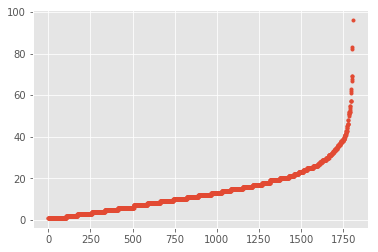

In [120]:
plt.plot(np.sort(genes[1]),'.')

In [121]:
(uni[1][0] + 2/3*uni[1][1] + 1/3*uni[1][2])/(uni[1][3] + 1/3*uni[1][1] + 2/3*uni[1][2])

0.6659220813349978

In [237]:
pi = pi_vals/G

In [238]:
fst = pd.DataFrame(index=pi.index,columns=pi.columns)
for s1 in pi.columns:
    for s2 in pi.index:
        fst.loc[s1,s2] = 1 - ((pi.loc[s1,s1]+pi.loc[s2,s2])/2)/pi.loc[s1,s2]

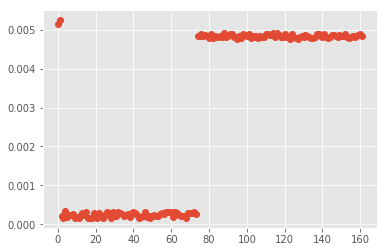

In [240]:
plt.plot(list(pi.loc["SRR9224017"]),'o')

In [ ]:
plt.plot(list(rel_ab.loc[tp_ordered]),'o')
plt.ylim([1e-2,1])
plt.semilogy()

In [ ]:
plt.plot(list(rel_ab.loc[tp_ordered])[1:],list(fst.iloc[0])[1:],'o')
#plt.ylim([1e-2,1])

In [ ]:
var_sites_df.plot.scatter(x="SRR9224070",y="SRR9224401")

In [ ]:
def calculate_pi_within_between(samples_host,species,chunk_size = 40000):
    
    if samples_host[0] == samples_host[1]:
        samples_host = [samples_host[0]]
    
    data_dir = config.data_directory
    snps_dir = f"{data_dir}snps/{species}"    
    
    pi_vals = pd.DataFrame(0,index=samples_host,columns=samples_host)
    df_depth_reader = pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",index_col=0,iterator=True,low_memory=False)
    df_refreq_reader = pd.read_csv(f"{snps_dir}/snps_ref_freq.txt.bz2",sep="\t",index_col=0, iterator=True,low_memory=False)
    
    df_depth = df_depth_reader.get_chunk(1)
    df_refreq = df_refreq_reader.get_chunk(1)

    tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")

    t1 = time.time()
    reader=True
    i=0
    S=0
    G=pd.Series(0,index=samples_host)

    L = len(samples_host)
    var_sites_df = pd.DataFrame(columns=samples_host)
    var_sites_depth_df = pd.DataFrame(columns=samples_host)

    while reader:
    
        df_depth = df_depth_reader.get_chunk(chunk_size)
        df_refreq = df_refreq_reader.get_chunk(chunk_size)
    
        df_depth = df_depth[samples_host]
        df_refreq = df_refreq[samples_host]
    
        if df_depth.shape[0] < chunk_size:
            reader=False
            sys.stderr.write("Complete")
        
        df_depth = df_depth[(df_depth > 5).all(1)]
    
        G += df_depth.shape[0]
    
        df_refreq = df_refreq.loc[df_depth.index]
    
        df_refreq = df_refreq.where(df_refreq > .05,0)
        df_refreq = df_refreq.where(df_refreq < .95,1)
    
        df_altfreq = 1 - df_refreq
    
        df_pi_mat = (df_refreq.T.values @ df_altfreq.values) + (df_altfreq.T.values @ df_refreq.values)
    
        pi_vals += df_pi_mat
    
        var_sites = np.abs(df_refreq[samples_host[-1]] - df_refreq[samples_host[0]]) > .8
    
        var_sites_df = var_sites_df.append(df_refreq.loc[var_sites])
        i+=1
        print(i)
    pi = pi_vals/G

    return(pi,G,var_sites_df)

In [ ]:
pi,G,var_sites_df = calculate_pi_within_between(["SRR9224529","SRR9224529"],"Bacteroides_fragilis_54507")

In [ ]:
pi.iloc[0][0]

In [ ]:
pi = (pi_vals/G)

In [ ]:
plt.plot(list(df_refreq[samples_host[0]]),list(df_refreq[samples_host[1]]),'.')
#plt.plot(list(df_refreq["SRR9224529"]),'x')

In [ ]:
s1 = samples_host[0]
s2 = samples_host[1]

1 - ((pi.loc[s1][s1] + pi.loc[s2][s2])/2)/((pi.loc[s1][s2] + pi.loc[s2][s1])/2)

In [ ]:
pi

In [ ]:
var_sites_df.plot.scatter(x=samples_host[0],y=samples_host[1])

In [ ]:
plt.plot(1 - (pi_vals/G).iloc[0],'.')
#plt.ylim([1e-5,1e-2])
#plt.semilogy()

In [ ]:
var_sites_depth_df = pd.read_csv(f"{config.analysis_directory}/pi/{host}/{species}_depth.txt.bz2",index_col=0).astype(float)
var_sites_df = pd.read_csv(f"{config.analysis_directory}/pi/{host}/{species}_freqs.txt.bz2",index_col=0).astype(float)

In [124]:
#var_sites_df = var_sites_df.replace(0,np.nan)
#var_sites_df = var_sites_df.replace(1,np.nan)

D = var_sites_depth_df.values
f = var_sites_df.values

D[D == 0] = np.nan

In [125]:
var_sites_df

,SRR9224066,SRR9224068,SRR9224069,SRR9224070,SRR9224071,SRR9224072,SRR9224073,SRR9224074,SRR9224020,SRR9224022,...,SRR9224112,SRR9224119,SRR9224249,SRR9224256,SRR9224288,SRR9224253,SRR9224258,SRR9224257,SRR9224470,SRR9224471
NZ_GG697149|87|C,0.882353,0.944444,0.916667,NaN,NaN,0.428571,0.571429,0.666667,NaN,0.375000,...,0.000000,0.222222,0.333333,0.222222,0.666667,NaN,0.000000,0.000000,NaN,NaN
NZ_GG697149|281|A,1.000000,1.000000,0.826087,0.600000,0.375000,0.470588,NaN,0.600000,NaN,0.833333,...,0.000000,0.166667,0.125000,0.222222,NaN,NaN,0.111111,0.100000,0.250000,0.000000
NZ_GG697149|311|G,0.111111,0.000000,0.190476,0.571429,0.428571,0.562500,0.428571,0.545455,NaN,0.285714,...,1.000000,0.800000,1.000000,0.666667,NaN,NaN,0.878049,0.833333,0.777778,1.000000
NZ_GG697149|339|C,0.181818,0.000000,0.217391,0.333333,0.444444,0.526316,0.300000,0.500000,NaN,0.428571,...,0.833333,0.750000,1.000000,0.687500,NaN,0.571429,0.914894,0.800000,0.714286,1.000000
NZ_GG697149|410|G,0.916667,0.960000,0.743590,0.700000,0.428571,0.631579,1.000000,0.615385,0.125000,NaN,...,0.285714,0.280000,0.250000,0.300000,0.166667,0.333333,0.074074,0.071429,0.300000,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NZ_GG697158|49415|G,0.941176,0.954545,0.882353,0.666667,NaN,0.571429,NaN,0.750000,NaN,NaN,...,NaN,0.000000,0.571429,0.636364,NaN,0.333333,0.041667,NaN,NaN,NaN
NZ_GG697159|7017|T,1.000000,1.000000,0.966667,1.000000,0.846154,0.875000,1.000000,0.900000,1.000000,0.750000,...,0.952381,0.777778,0.666667,1.000000,1.000000,0.882353,0.891892,0.875000,NaN,1.000000
NZ_GG697159|7758|C,1.000000,1.000000,0.833333,1.000000,0.833333,0.937500,0.777778,1.000000,0.888889,NaN,...,1.000000,0.833333,0.866667,0.818182,0.500000,0.894737,0.914286,0.875000,1.000000,0.923077
NZ_GG697159|7787|G,1.000000,1.000000,0.838710,1.000000,0.866667,0.937500,0.800000,0.909091,NaN,0.875000,...,0.937500,0.806452,0.846154,0.727273,0.500000,0.875000,0.888889,0.888889,1.000000,0.923077


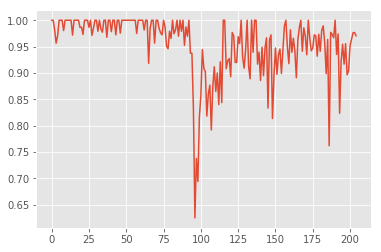

In [50]:
plt.plot(list(var_sites_df.iloc[8]))

In [51]:
from numba import jit

In [152]:
def make_distance_matrix(f,D,min_depth=5):
    S = 5000
   # S = f.shape[0]
    dist_mat_pol1 = np.zeros((S,S))
    dist_mat_pol2 = np.zeros((S,S))
    
 
    # good_inds_D = D >= min_depth
    # D = D*good_inds_D
    # D[D == 0] = np.nan
    
    for i in range(S - 1):
        fi1, Di1 = f[i], D[i]
        for j in range(i+1,S):
            fj1,Dj1 = f[j], D[j]
                        
            denom = (fi1 + fj1)*(1 - fi1 + 1 - fj1)
            num = 2*(Di1+Dj1)*((fi1 - fj1)**2)
            
            zeros = denom == 0
            nonzeros = zeros == False
            zero_weight = 1-len(denom[zeros])/S
            
            dist_mat_pol1[(i,j)] = zero_weight*np.nanmean(num[nonzeros]/denom[nonzeros],dtype='float32')
            fj2 = 1 - fj1
            denom2 = (fi1 + fj2)*(1 - fi1 + 1 - fj2)
            num2 = 2*(Di1+Dj1)*(fi1 - fj2)**2

            zeros2 = denom2 == 0
            nonzeros2 = zeros2 == False
            zero_weight2 = 1-len(denom2[zeros2])/S
            
            dist_mat_pol2[(i,j)] = zero_weight2*np.nanmean(num2[nonzeros2]/denom2[nonzeros2],dtype='float32')
            
            #if dist_mat_pol2_ij > dist_mat_pol1_ij:
            #    f[j] = fj2
            
           # dist_mat_pol[(i,j)] = min(dist_mat_pol1_ij,dist_mat_pol2_ij)
        
        print(i)
    
    #dist_mat = np.minimum(dist_mat_pol1,dist_mat_pol2)
    dist_mat_pol1 = dist_mat_pol1 + dist_mat_pol1.T
    dist_mat_pol2 = dist_mat_pol2 + dist_mat_pol2.T
    
    return(dist_mat_pol1, dist_mat_pol2)

In [153]:
t1 = time.time()
dist_mat_pol1,dist_mat_pol2 = make_distance_matrix(f,D)
dist_mat = np.minimum(dist_mat_pol1,dist_mat_pol2)
t2 = time.time()
t2 - t1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


4331.344718456268

In [162]:
df_dist = pd.DataFrame(dist_mat)

In [163]:
good_inds = pd.isnull(df_dist).any(axis=0) == False

In [164]:
df_dist = df_dist.loc[good_inds].T.loc[good_inds]

In [165]:
dist_mat = df_dist.values

In [58]:
eigs = np.abs(eigvals(csgraph.laplacian(dist_mat)))
clus_num = np.argmax(np.abs(np.diff(np.sort(eigs)[::-1][:-1]))) + 1
#clus_num = 3
clustering = SpectralClustering(n_clusters=clus_num,assign_labels='discretize',random_state=0,
                               affinity='precomputed_nearest_neighbors').fit(dist_mat)

In [59]:
clus_num

1

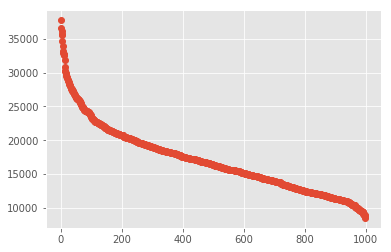

In [60]:
plt.plot(np.sort(eigs)[::-1][:-1],'o')

In [166]:
for i in range(dist_mat.shape[0]-1):
    for j in range(i+1,dist_mat.shape[0]):
        if dist_mat[i][j] != dist_mat[j][i]:
            print((i,j))
            print("Asymmetric")
            
            
            #dist_mat[i][j] = 100
            #dist_mat[j][i] = 100

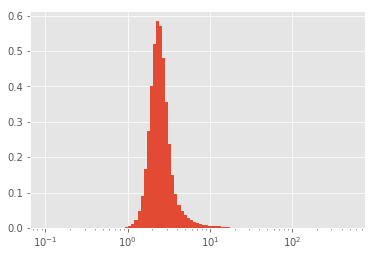

In [159]:
plt.hist(dist_mat.ravel(),bins=np.logspace(-1,2.7,100),density=True);
#plt.semilogy()
plt.semilogx();

In [167]:
linkage = hc.linkage(sp.distance.squareform(dist_mat), method='average')

[]

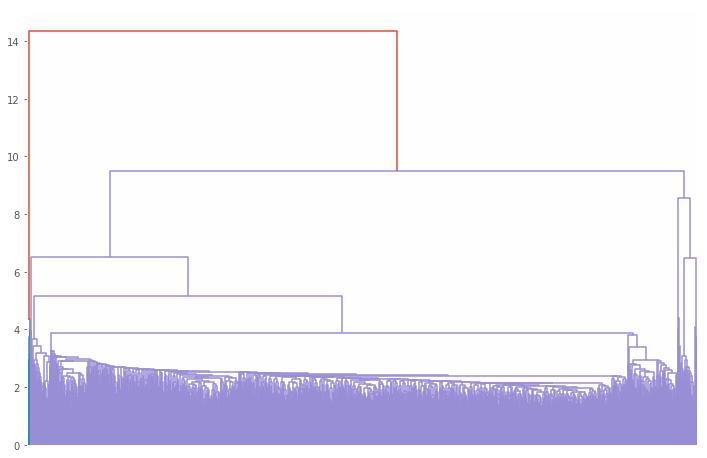

In [168]:
fig,ax = plt.subplots(figsize=(12,8))
hc.dendrogram(
    linkage,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
);
ax.set_xticklabels([])

In [183]:
clus_num = max(hc.fcluster(linkage,3.5,criterion="distance"))
clusters = []
for i in range(clus_num):
    c = np.argwhere(hc.fcluster(linkage,3.5,criterion="distance") == i).ravel()
    if len(c) > 500:
        clusters.append(c)
    #c = np.argwhere((clustering.labels_ == i)).ravel()
    #clusters.append(c)
    #if len(c) > 100:
    #    clusters.append(c)

In [184]:
## polarize
F = []

for i in range(len(clusters)):
   # cdists = np.mean(dist_mat[clusters[i]][:,clusters[i]],axis=0)
   # clusters[i] = np.argwhere(cdists < 20).ravel()
    cluster = clusters[i]
    f_c = f[cluster]
    #print(f_c)
    for j in range(len(cluster)):
       # print(i,j)
        if dist_mat_pol1[cluster[0],cluster[j]] > dist_mat_pol2[cluster[0],cluster[j]]:
            print(f"{i} polarize")
                #print(f_c[i])
            f_c[j] = 1 - f_c[j]
                #print(f_c[i])
    F.append(f_c)

0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize
0 polarize

0 polarize
0 polarize
0 polarize
0 polarize


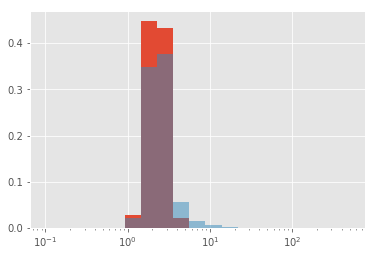

In [185]:
plt.hist(dist_mat[clusters[0]][:,clusters[0]].ravel(),bins=np.logspace(-1,2.7,20),density=True)
plt.semilogx()

plt.hist(dist_mat.ravel(),bins=np.logspace(-1,2.7,20),density=True,alpha=.5);

In [186]:
X = var_sites_df

In [187]:
for i in range(len(clusters)):

    X.iloc[clusters[i]] = F[i]

X = X[tp_matched[samples_host].sort_values().index]

(0, 1)

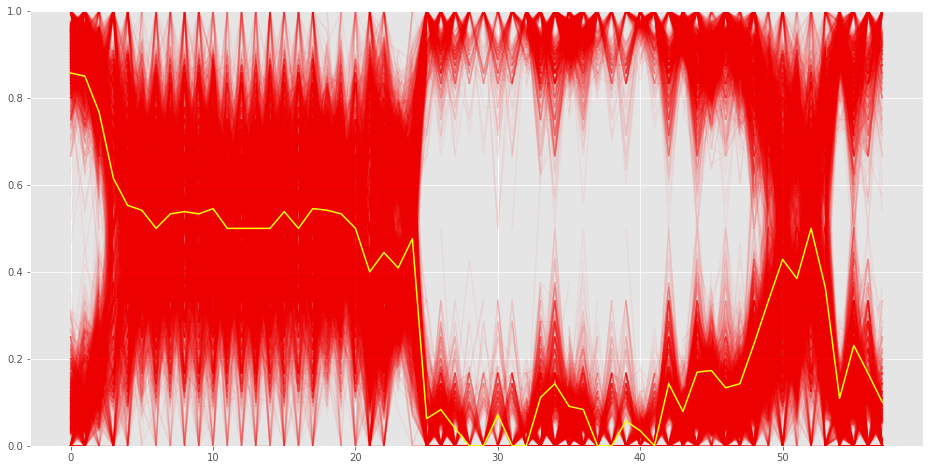

In [188]:
fig,ax = plt.subplots(figsize=(16,8))

#C = 1
#ax.plot(F[C].T,alpha=.05,color="grey");
#ax.plot([np.nanmedian(e) for e in F[C].T],color="k")

C = 0
ax.plot(F[C].T,alpha=.05,color="red");
ax.plot([np.nanmedian(e) for e in F[C].T],color="yellow");

ax.set_ylim([0,1])
#C = 3
#ax.plot(1 - F[C].T,alpha=.05,color="purple");
#ax.plot(1 - np.array([np.nanmedian(e) for e in F[C].T]),color="green");

#C = 1
#ax.plot(1 - F[C].T,alpha=.05,color="purple");
#ax.plot(1 - np.array([np.nanmedian(e) for e in F[C].T]),color="green");

In [189]:
info.iloc[clusters[0]]

,mean_freq,mean_depth,site_prev,allele_props,site_type,gene_id,amino_acids,snps
site_id,,,,,,,,
NZ_GG697149|1|C,0.000000,0.000000,0.000000,NaN,NC,NaN,NaN,NaN
NZ_GG697149|2|C,0.011628,0.011628,0.000000,A:0.0|C:1.0|T:0.0|G:0.0,NC,NaN,NaN,NaN
NZ_GG697149|3|G,0.058140,0.093023,0.000000,A:0.0|C:0.375|T:0.0|G:0.625,NC,NaN,NaN,NaN
NZ_GG697149|4|G,0.151163,0.174419,0.000000,A:0.0|C:0.0|T:0.0|G:1.0,NC,NaN,NaN,NaN
NZ_GG697149|5|C,0.174419,0.197674,0.000000,A:0.0|C:1.0|T:0.0|G:0.0,NC,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
NZ_GG697149|4951|C,1.000000,13.639535,0.976744,A:0.0|C:1.0|T:0.0|G:0.0,4D,411483.3.peg.6,A:T|C:T|T:T|G:T,A:SYN|C:SYN|T:SYN|G:SYN
NZ_GG697149|4952|G,1.000000,14.093023,0.976744,A:0.0|C:0.0|T:0.0|G:1.0,1D,411483.3.peg.6,A:M|C:R|T:K|G:T,A:NS|C:NS|T:NS|G:SYN
NZ_GG697149|4953|T,1.000000,14.023256,0.988372,A:0.0|C:0.0|T:1.0|G:0.0,1D,411483.3.peg.6,A:S|C:A|T:T|G:P,A:NS|C:NS|T:SYN|G:NS


In [190]:
uni = np.unique(info.iloc[clusters[0]]['site_type'],return_counts=True)
(uni[1][0] + 2/3*uni[1][1] + 1/3*uni[1][2])/(uni[1][3] + 1/3*uni[1][1] + 2/3*uni[1][2])

3.081190301249081

In [191]:
uni

(array(['1D', '2D', '3D', '4D', 'NC'], dtype=object),
 array([2379,  597,   56,  671,  610]))

In [192]:
uni[1][0]/uni[1][3]

3.5454545454545454

In [111]:
genes = np.unique(info.iloc[clusters[2]]["gene_id"].dropna(),return_counts=True)

In [112]:
genes

(array(['435590.9.peg.1'], dtype=object), array([334]))

In [435]:
plt.plot(np.array([np.nanmedian(e) for e in F[1].T]) + np.array([np.nanmedian(e) for e in F[0].T]) - (1- np.array([np.nanmedian(e) for e in F[2].T])))

IndexError: list index out of range

(0, 1)

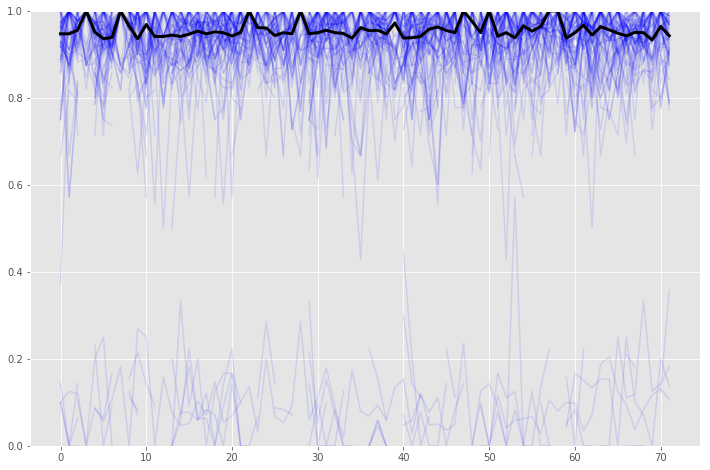

In [477]:
fig,ax = plt.subplots(figsize=(12,8))

#C = 1
#ax.plot(1-X.T.values[:,clusters[C][:100]],color="red",alpha=.1,zorder=1);
#ax.plot(list(1-X.iloc[clusters[C]].median()),lw=3,color="yellow",zorder=2)
#ax.set_ylim([-0.03,1.03])

C = 1
ax.plot(X.T.values[:,clusters[C][:100]],color="blue",alpha=.1,zorder=1);
ax.plot(list(X.iloc[clusters[C]].median()),color="k",lw=3,zorder=2)
ax.set_ylim([0,1])

#C = 2
#ax.plot(1-X.T.values[:,clusters[C][:100]],color="brown",alpha=.1,zorder=1);
#ax.plot(list(1-X.iloc[clusters[C]].median()),color="orange",lw=3,zorder=2)
#ax.set_ylim([0,1])

#C = 5
#ax.plot(X.T.values[:,clusters[C][:100]],color="green",alpha=.1,zorder=1);
#ax.plot(list(X.iloc[clusters[C]].median()),color="purple",lw=3,zorder=2)

#C = 4
#ax.plot(X.T.values[:,clusters[C][:100]],color="green",alpha=.1,zorder=1);
#ax.plot(list(X.iloc[clusters[C]].median()),color="purple",lw=3,zorder=2)
#ax.set_ylim([0,1])
#ax.plot(var_sites_df[tp_matched[samples_host].sort_values().index].T.values[:,c2[:500]],color="blue",alpha=.1);

In [ ]:
centroids = []

for cluster in clusters:
    print(len(cluster))
    centroids.append(list(X.iloc[cluster].median()))
centroids = np.array(centroids)

In [ ]:
c_df = pd.DataFrame(centroids)

In [ ]:
c_df.loc[1] = 1 - c_df.loc[1]

In [ ]:
c_df.loc[2] = 1 - c_df.loc[2]

In [ ]:
pd.DataFrame(centroids).loc[[1,2,0]].T.plot(figsize=(12,8))

In [ ]:
plt.plot(centroids.T[:,[1]]);

In [ ]:
np.corrcoef(centroids)

In [ ]:
plt.plot(list(pd.DataFrame(centroids[[1,2]]).loc[0] - pd.DataFrame(centroids[[1,2]]).loc[1]))

plt.plot(centroids[3])

plt.ylim([0,1])

In [ ]:
pi = list((pi_vals/G).loc[tp_matched[samples_host].sort_values().index])

In [ ]:
plt.plot(pi,'o')
plt.semilogy()
plt.ylim([1e-4,1e0])

In [ ]:
a,b,loc0,scale=beta.fit(pi)

plt.plot(pi,'o')
plt.semilogy()
plt.ylim([1e-4,1e-2]);

In [ ]:
lower,upper = np.log10(.8*min(pi)),np.log10(1.2*max(pi))
xx = np.logspace(lower,upper,1000)

fig,ax = plt.subplots(figsize=(12,8))
ax.hist(pi,bins=np.logspace(lower,upper,15),density=True,ec="k");
ax.plot(xx,beta.pdf(xx,a,b,loc0,scale),'r',color="k",lw=2)
ax.semilogx()

In [ ]:
## implement pi between for each subsequent pair of timepoints

host = "am"
tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")
samples_host = tp_matched[config.Poyet_samples[host]].sort_values().index[[0,-1]]
pi_between_vals = pd.Series(0,index=samples_host)
print(samples_host)
chunk_size = 40000
G = 0
df_depth_reader = pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",usecols=samples_host,iterator=True,low_memory=False)
df_refreq_reader = pd.read_csv(f"{snps_dir}/snps_ref_freq.txt.bz2",sep="\t",iterator=True,usecols=samples_host,low_memory=False)
df_depth = df_depth_reader.get_chunk(1)
df_refreq = df_refreq_reader.get_chunk(1)

t1 = time.time()

reader=True
i=0
while reader:
    
    df_depth = df_depth_reader.get_chunk(chunk_size)[samples_host]   
    df_refreq = df_refreq_reader.get_chunk(chunk_size)[samples_host]
    
    if df_depth.shape[0] < chunk_size:
        reader=False
        print("Complete")
    
    medians = df_depth.T.median()
    good_inds = medians[medians >= 1].index
    G+=len(good_inds)
    df_depth = df_depth.loc[good_inds]
    df_refreq = df_refreq.loc[good_inds]
    df_altfreq = (1-df_refreq).loc[good_inds]

    v = (df_refreq[samples_host[:-1]].values*df_altfreq[samples_host[1:]].values) 
    + (df_altfreq[samples_host[:-1]].values*df_refreq[samples_host[1:]].values)

    pi_between_vals += np.sum(v,axis=0)
    i+=1
    t2 = time.time()
    print(f"step {i}, time elapsed {t2 - t1} \n")
    if i > 25:
        reader=False
        print("Complete")  
pi_between_vals = pi_between_vals/G

In [ ]:
len(good_inds)

In [ ]:
lower,upper = np.log10(.8*min(pi)),np.log10(1.2*max(pi))
xx = np.logspace(lower,upper,1000)

fig,ax = plt.subplots(figsize=(12,8))
ax.hist(pi,bins=np.logspace(lower,upper,12),density=True,ec="k");
ax.plot(xx,beta.pdf(xx,a,b,loc0,scale),'r',color="k",lw=2)
ax.semilogx()

In [ ]:
plt.plot(list(pi_between_vals[samples_host[:-1]]),'o')
plt.semilogy()
plt.ylim([1e-4,1])

In [ ]:
fst = []
for i in range(202):
    fst.append(1 - ((pi_vals[samples_host[i]] + pi_vals[samples_host[i+1]])/2)/pi_between_vals[samples_host[i]])

In [ ]:
plt.plot(fst,'.')

In [ ]:
pi_vals = pd.Series(0,index=samples)
df_depth_reader = pd.read_csv(f"{snps_dir}/snps_depth.txt.bz2",sep="\t",usecols=samples,iterator=True,low_memory=False)
df_refreq_reader = pd.read_csv(f"{snps_dir}/snps_ref_freq.txt.bz2",sep="\t",iterator=True,usecols=samples,low_memory=False)
df_depth = df_depth_reader.get_chunk(1)
df_refreq = df_refreq_reader.get_chunk(1)
pi_vals = pd.Series(0,index=samples)
    
df_depth = df_depth_reader.get_chunk(chunk_size)[samples]   
df_refreq = df_refreq_reader.get_chunk(chunk_size)[samples]

    
medians = df_depth.T.median()
good_inds = medians[medians >= 5].index
G+=len(good_inds)
df_depth = df_depth.loc[good_inds]
df_refreq = df_refreq.loc[good_inds]
df_altfreq = (1-df_refreq).loc[good_inds]
df_refreq[samples[:-1]].values*df_altfreq[samples[1:]].values

In [ ]:
df_refreq[samples[:-1]][samples[:2]]

In [ ]:
df_altfreq[samples[1:]]

In [ ]:
tp_matched = pd.read_pickle(f"{config.metadata_directory}Poyet_collection_dates.pkl")
samples = tp_matched[config.Poyet_samples[host]].sort_values().index

In [ ]:
pi_vals[samples[:-1]]

In [ ]:
fst = []
for i in range(202):
    fst.append(1 - ((pi_vals[samples[i]] + pi_vals[samples[i+1]])/2)/pi_between_vals[samples[i]])

In [ ]:
plt.plot(fst,'o')